<a href="https://colab.research.google.com/github/Raul803/integral/blob/main/Raul_Bogota2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas                  as pd
import numpy                   as np
import matplotlib.pyplot       as plt
# This statement allow to display plot without asking to 
%matplotlib inline
 # always make it pretty 
plt.style.use('ggplot')
!pip install sktime

# *Montar el Drive local*

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


***Cargar la Data extraida desde la Web.***

In [ ]:
df = pd.read_csv('drive/My Drive/DataBase/Bogota.csv',sep=';',encoding='ISO-8859-1')
df.head()

,FECHA_INICIO_SINTOMAS,FECHA_DIAGNOSTICO,CIUDAD,LOCALIDAD_ASIS,EDAD,UNI_MED,SEXO,FUENTE_O_TIPO_CONTAGIO,UBICACION,ESTADO
0,26/02/2020,06/03/2020,Bogotá,Usaquén,19,1,F,Importado,Casa,Recuperado
1,04/03/2020,10/03/2020,Bogotá,Engativá,22,1,F,Importado,Casa,Recuperado
2,07/03/2020,10/03/2020,Bogotá,Engativá,28,1,F,Importado,Casa,Recuperado
3,06/03/2020,12/03/2020,Bogotá,Fontibón,36,1,F,Importado,Casa,Recuperado
4,06/03/2020,12/03/2020,Bogotá,Kennedy,42,1,F,Importado,Casa,Recuperado


***Agrupar por Dia para Graficar.***

In [ ]:
data = pd.DataFrame(columns=['Fecha','NoPasc']) #,
data.Fecha = df.FECHA_DIAGNOSTICO.T
data.NoPasc = 1
d=data.groupby('Fecha').count()
d=d.sort_values('Fecha')

***Graficas: Por Día***

Se muestran los casos positivos por cada dia desde el inicio de la pandemia

<BarContainer object of 258 artists>

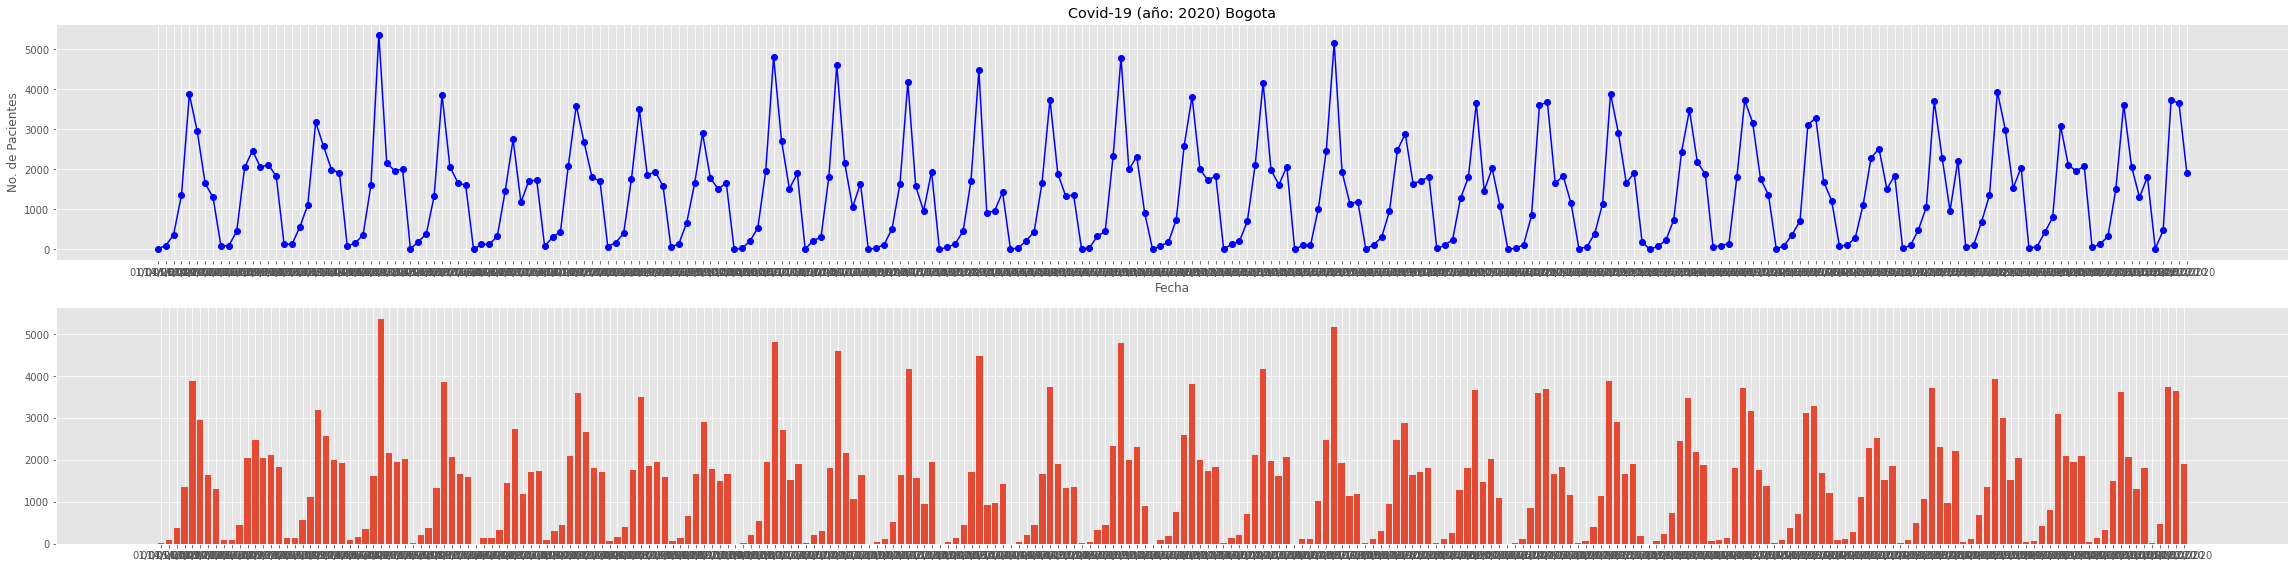

In [ ]:
import warnings
warnings.filterwarnings('ignore')

fig = plt.figure(figsize=(40,20))
fig.tight_layout()
plt.xticks(range(int(len(d.NoPasc)/100)))
ax = plt.subplot(4,1,1)
plt.plot(d.index,d.NoPasc,'bo-') # Lineas
ax.set_title('Covid-19 (año: 2020) Bogota')
ax.set_xlabel('Fecha')
ax.set_ylabel('No. de Pacientes')
ax = plt.subplot(4,1,2)
plt.bar(d.index,d.NoPasc)

***Agrupar por Mes para Graficar.***

In [ ]:
# Agrupando por Mes
data = pd.DataFrame([df.FECHA_DIAGNOSTICO]).T
data['FECHA_DIAGNOSTICO'] = pd.to_datetime(data['FECHA_DIAGNOSTICO'])
data['NoPac']=1
data.set_index('FECHA_DIAGNOSTICO', inplace=True)
Data = data.copy() # Cramos una copia para el siguiente paso
data = data.resample('M').sum()

***Graficas: Por Mes***

Se muestran los casos positivos por cada mes desde el inicio de la pandemia

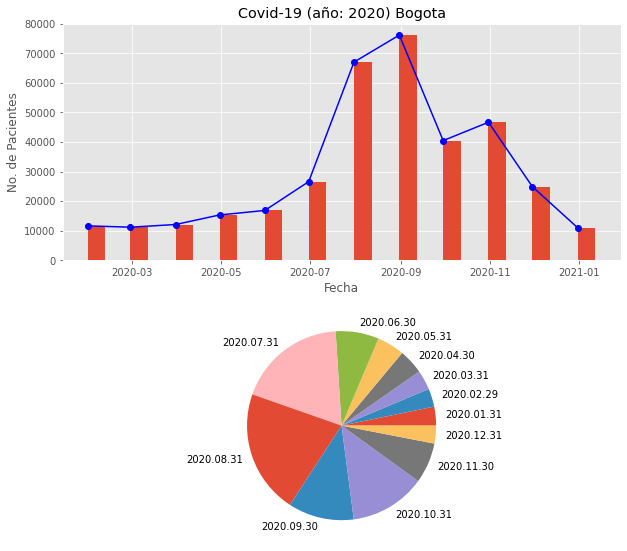

In [ ]:
fig = plt.figure(figsize=(10,20))
fig.tight_layout()
plt.xticks(range(int(len(data.NoPac)/2)))
ax = plt.subplot(4,1,1)

plt.bar(data.index.values,data['NoPac'],align="edge", width = 12.0, linewidth = 100.0 )
plt.plot(data.index,data['NoPac'],'bo-') # Lineas
ax.set_title('Covid-19 (año: 2020) Bogota')
ax.set_xlabel('Fecha')
ax.set_ylabel('No. de Pacientes')
ax = plt.subplot(4,1,2)
a = plt.pie(data.NoPac,labels=[pd.to_datetime(x).strftime('%Y.%m.%d') for x in data.index])

# **Creando un Modelo:**

Vamos a generar un modelo en base a la serie de tiempo.

(<Figure size 1152x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ffab18f4a90>)

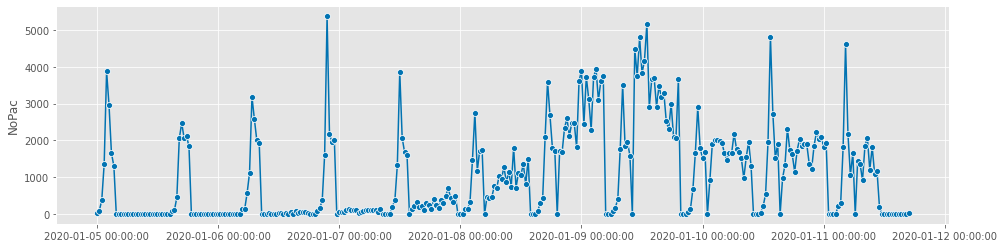

In [ ]:
from sktime.utils.plotting import plot_series
# Creamos la serie de Tiempo. Basada en los dias desde el incio de la pandemia.
index = pd.date_range('2020-01-04', periods=336, freq='D')
data = Data.copy()
data = data.resample('D').sum()
series = pd.Series(data.NoPac, index=index)
plot_series(series) # Gráfica de la serie de tiempo creada

# **Nota:**

Debemos tener mucho cuidado como particionamos la data. Una mala idea seria tratar de particionar utilizando *split* de *sklearn*.  En el ejemplo siguiente, los puntos amarillos serian los puntos para aplicar en el test.  Pero es una mala idea ya que estos se mesclan conlos datos de entrenamiento.

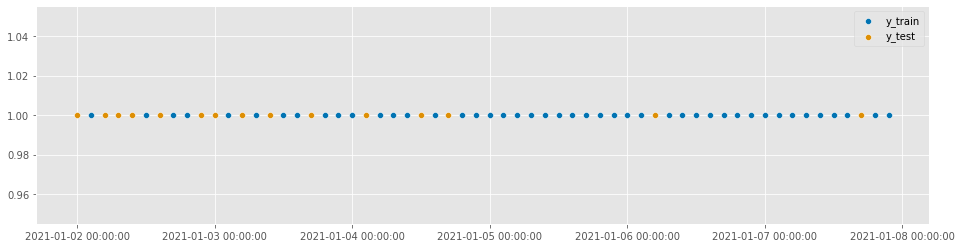

In [ ]:
from sklearn.model_selection import train_test_split
y_train, y_test = train_test_split(series)
plot_series(y_train.sort_index(), y_test.sort_index(), labels=["y_train", "y_test"]);

Una mejor estrategia. De esta forma no se mesclan los datos de entrenamiento con los datos de testeo.

In [ ]:
from sktime.forecasting.model_selection import temporal_train_test_split
y_train, y_test = temporal_train_test_split(series, test_size=60)
plot_series(y_train, y_test, labels=["y_train", "y_test"]);
print(y_train.shape[0], y_test.shape[0])

ValueError: ignored

Ahora, vamos a crear nuestro horizonte.

In [ ]:
from sktime.forecasting.base import ForecastingHorizon
horizonte_absoluto = ForecastingHorizon(y_test.index, is_relative=False)

Vamos a probar nuestro primer modelo.

In [ ]:
from sktime.forecasting.naive import NaiveForecaster
from sktime.performance_metrics.forecasting import smape_loss

forecaster = NaiveForecaster(strategy="last")
forecaster.fit(y_train)
y_pred = forecaster.predict(horizonte_absoluto)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
print('SMAPE en TEST =', smape_loss(y_pred, y_test))

ValueError: ignored

En el modelo anterior el **sMAPE** nos esta mostrando un valormuy alto, lo que siginfica quenuestro modelo esta muy lejos de ser bueno. Esto se puede comprobar fácilmente al observar la gráfica de la predicción.

Si ajustamos ligeramente nuestro modelo, indicando que deseamos una ventana de tiempo basada en un mes, tendriamos un mejor modelo.

In [ ]:
forecaster = NaiveForecaster(strategy="last", sp=60)
forecaster.fit(y_train)
y_pred = forecaster.predict(horizonte_absoluto)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
print('SMAPE en TEST =', smape_loss(y_pred, y_test))

ValueError: ignored

Tanto la gráfica como el valor del error porcentual absoluto medio simétrico nos lo confirman.

# **Que pasará el próximo año:**
Vamos a predecir que ocurriria en los primeros dos meses del proximo año, según nuestro modelo.


In [ ]:
index = pd.date_range('2021-01-01', periods=60, freq='D')
series = pd.Series(1, index=index)
horizonte_2021 = ForecastingHorizon(series.index, is_relative=False)
print(horizonte_2021)


NameError: ignored

In [ ]:
y_pred = forecaster.predict(horizonte_2021)
plot_series(y_pred,labels=["y_pred"]);
print(y_pred.head(10))


NameError: ignored

In [ ]:
df.head()

,FECHA_INICIO_SINTOMAS,FECHA_DIAGNOSTICO,CIUDAD,LOCALIDAD_ASIS,EDAD,UNI_MED,SEXO,FUENTE_O_TIPO_CONTAGIO,UBICACION,ESTADO
0,26/02/2020,06/03/2020,Bogotá,Usaquén,19,1,F,Importado,Casa,Recuperado
1,04/03/2020,10/03/2020,Bogotá,Engativá,22,1,F,Importado,Casa,Recuperado
2,07/03/2020,10/03/2020,Bogotá,Engativá,28,1,F,Importado,Casa,Recuperado
3,06/03/2020,12/03/2020,Bogotá,Fontibón,36,1,F,Importado,Casa,Recuperado
4,06/03/2020,12/03/2020,Bogotá,Kennedy,42,1,F,Importado,Casa,Recuperado


In [ ]:
d=df.groupby('LOCALIDAD_ASIS').count()
data = d['FECHA_DIAGNOSTICO']
data


LOCALIDAD_ASIS
Antonio Nariño         4775
Barrios Unidos         6852
Bosa                  28626
Chapinero              7614
Ciudad Bolívar        23409
Engativá              36369
Fontibón              15931
Fuera de Bogotá        2913
Kennedy               45429
La Candelaria          1471
Los Mártires           4630
Puente Aranda         14071
Rafael Uribe Uribe    17238
San Cristóbal         17438
Santa Fe               5912
Sin dato              32194
Suba                  45610
Teusaquillo            6494
Tunjuelito             9198
Usaquén               20203
Usme                  13539
Name: FECHA_DIAGNOSTICO, dtype: int64

In [ ]:
d=df.groupby('ESTADO').count()
data = d['FECHA_DIAGNOSTICO']
data

ESTADO
Fallecido                                 8327
Fallecido No aplica No causa Directa      1092
Grave                                      734
Leve                                     15847
Moderado                                  3713
Recuperado                              330203
Name: FECHA_DIAGNOSTICO, dtype: int64

In [ ]:
d=df.groupby('EDAD').count()
# data = d['EDAD']
d

,FECHA_INICIO_SINTOMAS,FECHA_DIAGNOSTICO,CIUDAD,LOCALIDAD_ASIS,UNI_MED,SEXO,FUENTE_O_TIPO_CONTAGIO,UBICACION,ESTADO
EDAD,,,,,,,,,
1,1013,1674,1674,1674,1674,1674,1674,1674,1674
2,896,1478,1478,1478,1478,1478,1478,1478,1478
3,811,1423,1423,1423,1423,1423,1423,1423,1423
4,835,1520,1520,1520,1520,1520,1520,1520,1520
5,865,1568,1568,1568,1568,1568,1568,1568,1568
...,...,...,...,...,...,...,...,...,...
101,13,15,15,15,15,15,15,15,15
102,3,5,5,5,5,5,5,5,5
103,2,2,2,2,2,2,2,2,2
